In [1]:
#aplicamos target encoding para las variables categoricas
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300
})

In [3]:
df_new = pd.read_csv('datos_predic_estudiantes.csv')
df_new.head()

,Facultad,Carrera,Día,H_Inicio,H_Salida,Año_Inicio,Año_Fin,Total Estudiantes
0,ICA,CIVIL,JUEVES,7,9,2020,2020,63
1,ICA,CIVIL,MIERCOLES,7,9,2020,2020,68
2,ICA,COMPUTACION,JUEVES,11,13,2020,2020,17
3,FILO,P INFORMATICA,VIERNES,8,10,2020,2020,6
4,ARQ,ARQUITECTURA,MARTES,7,9,2020,2020,19


In [4]:
import pandas as pd
import category_encoders as ce

# Suponiendo que df contiene las columnas: 'Día', 'Facultad', 'Carrera', 'Total_Estudiantes'

# 1. Target Encoding para 'Carrera'
df_encoded = df_new.copy()
target_col = 'Total Estudiantes'

# Aplicar Target Encoding a 'Carrera'
encoder = ce.TargetEncoder(cols=['Carrera'])
df_encoded['Carrera'] = encoder.fit_transform(df_encoded['Carrera'], df_encoded[target_col])

# 2. One-Hot Encoding para 'Día' y 'Facultad'
df_encoded = pd.get_dummies(df_encoded, columns=['Día', 'Facultad'])

# Verifica resultado
print(df_encoded.head())


     Carrera  H_Inicio  H_Salida  Año_Inicio  Año_Fin  Total Estudiantes  \
0  42.622369         7         9        2020     2020                 63   
1  42.622369         7         9        2020     2020                 68   
2  38.905576        11        13        2020     2020                 17   
3  32.749519         8        10        2020     2020                  6   
4  32.383399         7         9        2020     2020                 19   

   Día_JUEVES  Día_LUNES  Día_MARTES  Día_MIERCOLES  Día_VIERNES  \
0        True      False       False          False        False   
1       False      False       False           True        False   
2        True      False       False          False        False   
3       False      False       False          False         True   
4       False      False        True          False        False   

   Facultad_AGR  Facultad_ARQ  Facultad_CIENCIAS  Facultad_CQ  \
0         False         False              False        False   
1   

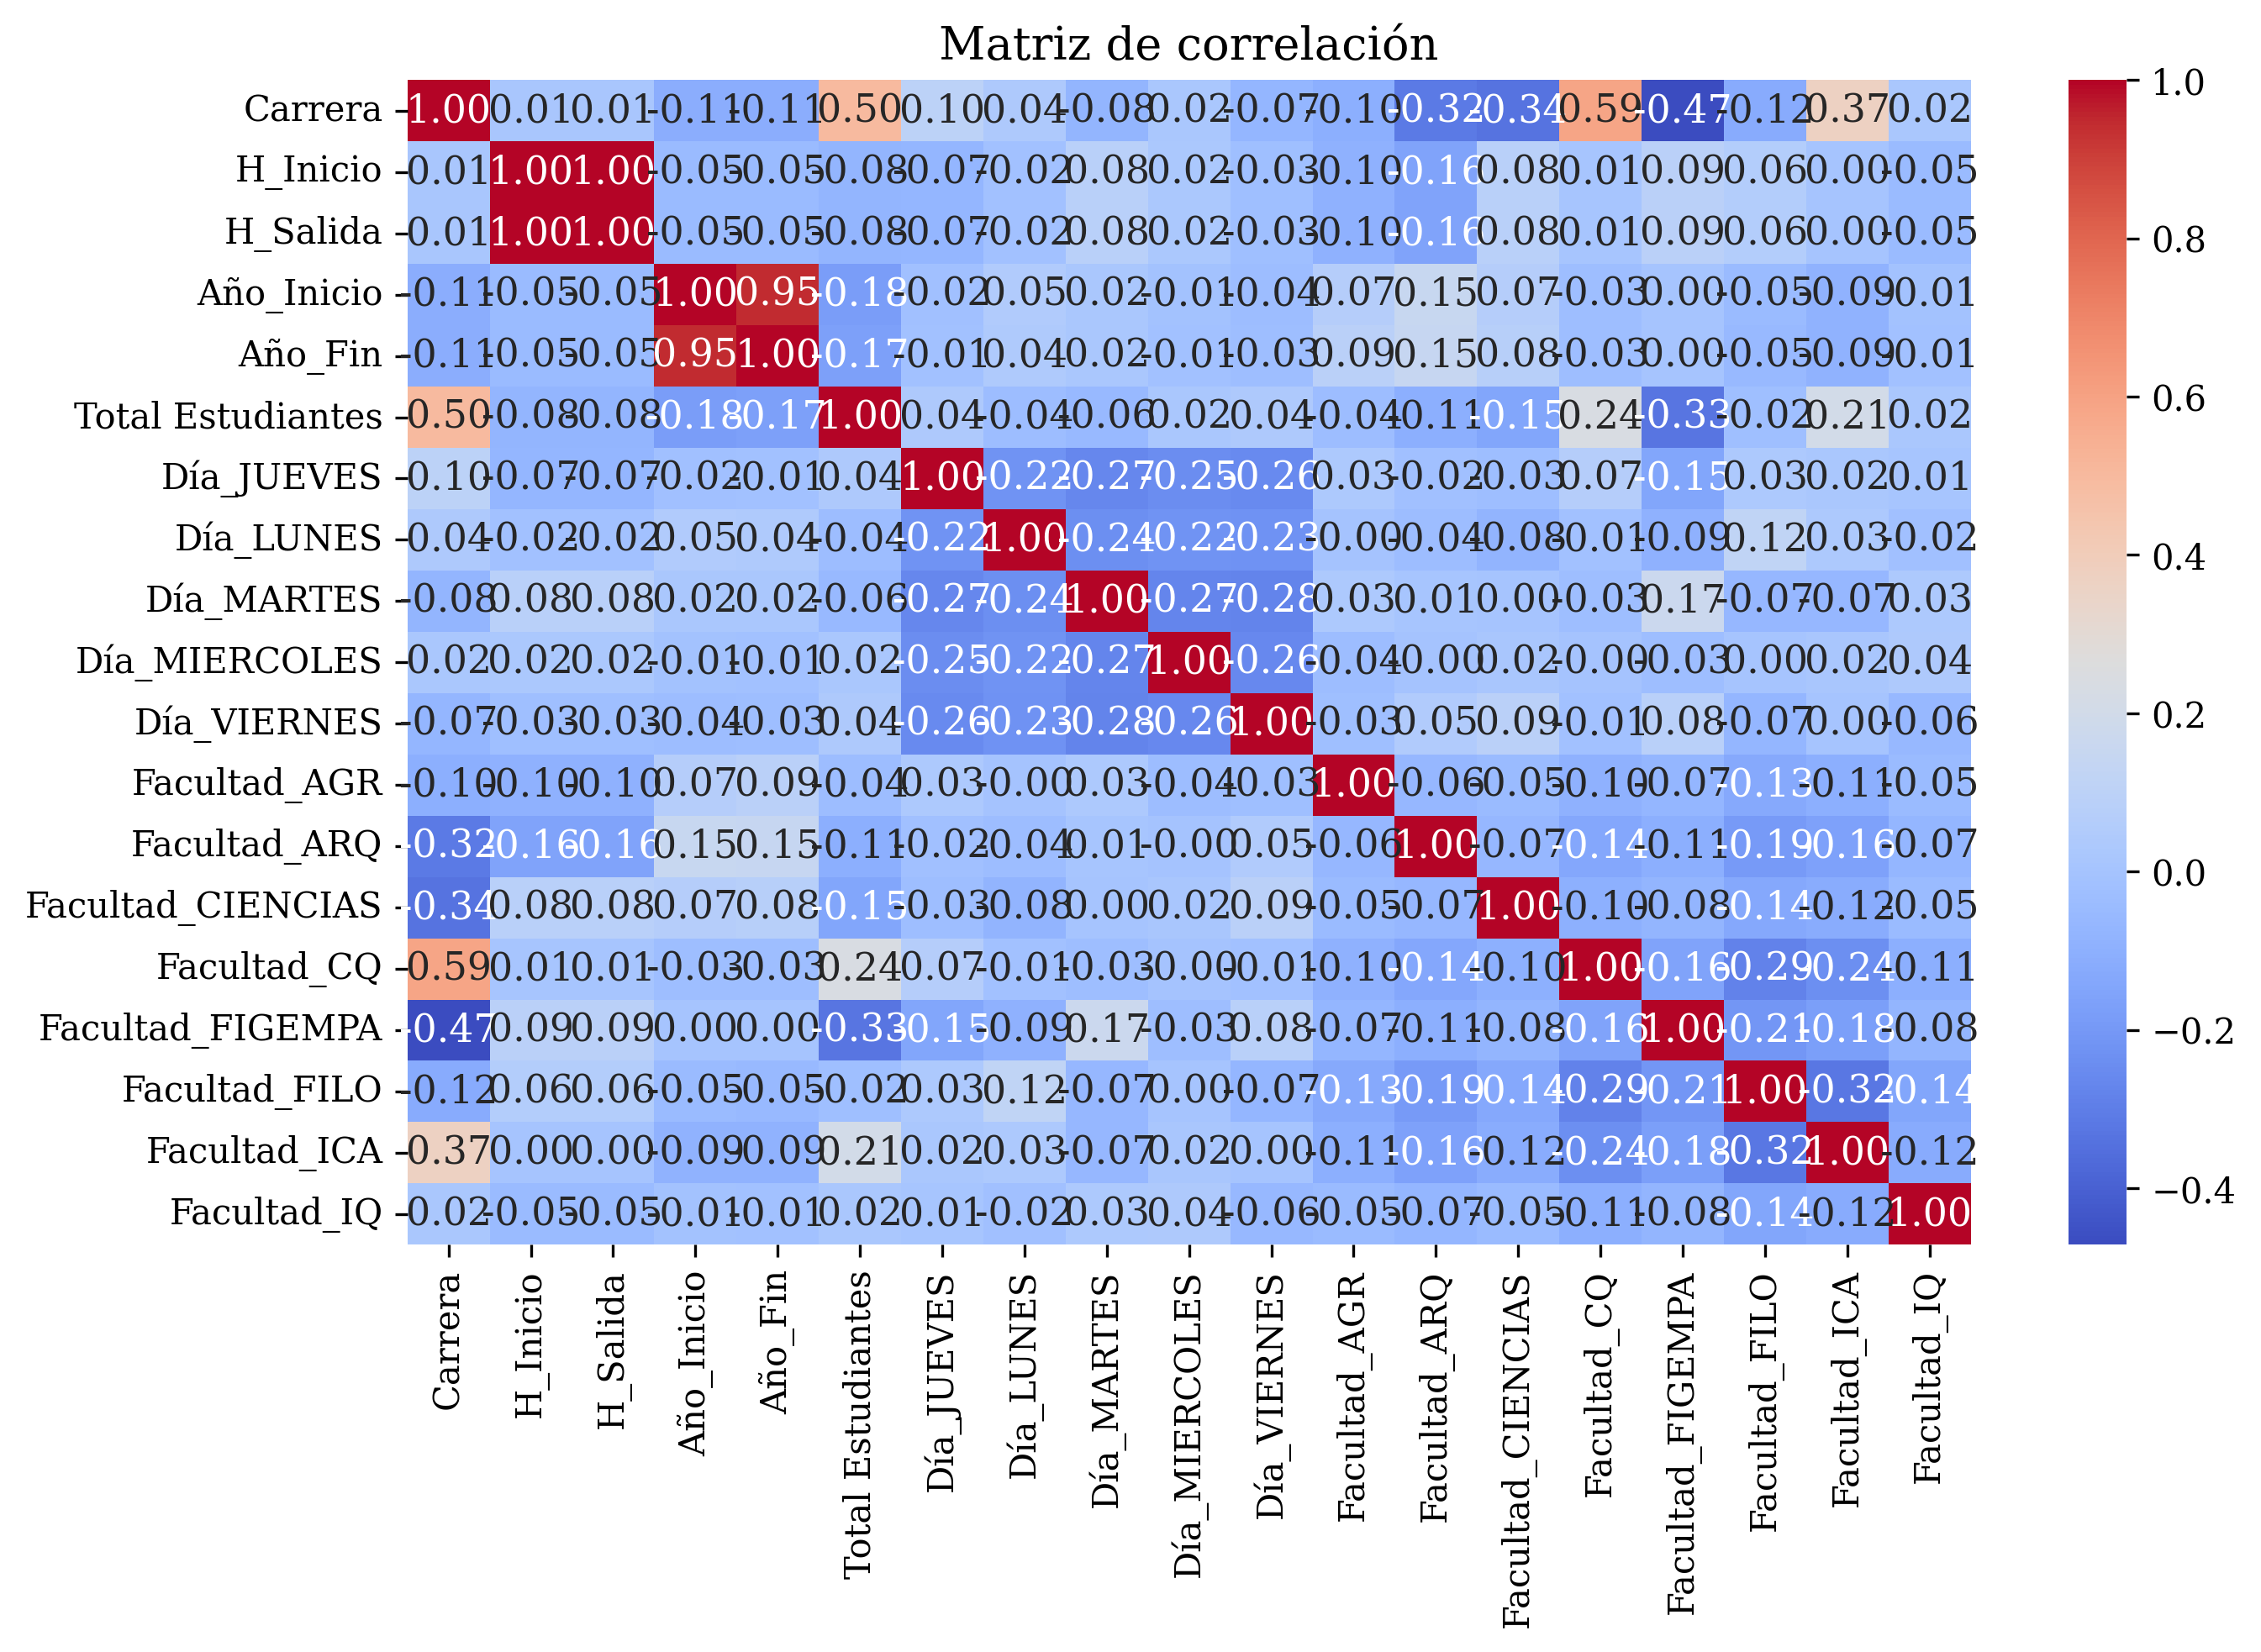

In [5]:
#visualizamos la matriz de correlacion
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación")
plt.show()

In [6]:
# Especifica tu variable objetivo
target = 'Total Estudiantes'

# Calcular la correlación de todas las variables con respecto a la variable objetivo
correlaciones = df_encoded.corr(numeric_only=True)[target].sort_values(ascending=False)

# Definir umbrales de alta y baja correlación (ajustables)
umbral_alta = 0.5
umbral_baja = 0.1

# Filtrar las variables con alta y baja correlación
alta_corr = correlaciones[abs(correlaciones) >= umbral_alta]
baja_corr = correlaciones[(abs(correlaciones) > 0) & (abs(correlaciones) <= umbral_baja)]

# Mostrar resultados
print("Variables con ALTA correlación:")
print(alta_corr)

print("\nVariables con BAJA correlación:")
print(baja_corr)

Variables con ALTA correlación:
Total Estudiantes    1.0
Name: Total Estudiantes, dtype: float64

Variables con BAJA correlación:
Día_JUEVES       0.037763
Día_VIERNES      0.037033
Facultad_IQ      0.021698
Día_MIERCOLES    0.018111
Facultad_FILO   -0.023804
Día_LUNES       -0.036914
Facultad_AGR    -0.039543
Día_MARTES      -0.056440
H_Inicio        -0.078188
H_Salida        -0.078607
Name: Total Estudiantes, dtype: float64


In [7]:
# Conjunto de validación: Año_Inicio = 2024 y Año_Fin = 2025
df_val = df_encoded[(df_encoded['Año_Inicio'] == 2024) & (df_encoded['Año_Fin'] == 2025)]

# Conjunto de entrenamiento: todos los demás
df_train = df_encoded[~((df_new['Año_Inicio'] == 2024) & (df_encoded['Año_Fin'] == 2025))]

In [8]:
df_train.head()

,Carrera,H_Inicio,H_Salida,Año_Inicio,Año_Fin,Total Estudiantes,Día_JUEVES,Día_LUNES,Día_MARTES,Día_MIERCOLES,Día_VIERNES,Facultad_AGR,Facultad_ARQ,Facultad_CIENCIAS,Facultad_CQ,Facultad_FIGEMPA,Facultad_FILO,Facultad_ICA,Facultad_IQ
0,42.622369,7,9,2020,2020,63,True,False,False,False,False,False,False,False,False,False,False,True,False
1,42.622369,7,9,2020,2020,68,False,False,False,True,False,False,False,False,False,False,False,True,False
2,38.905576,11,13,2020,2020,17,True,False,False,False,False,False,False,False,False,False,False,True,False
3,32.749519,8,10,2020,2020,6,False,False,False,False,True,False,False,False,False,False,True,False,False
4,32.383399,7,9,2020,2020,19,False,False,True,False,False,False,True,False,False,False,False,False,False


In [9]:
# preparamos los datos para el modelo

from sklearn.model_selection import train_test_split

# Separar variables predictoras y objetivo
X = df_train.drop(columns=['Total Estudiantes'])
y = df_train['Total Estudiantes']

# División del 80% para entrenamiento y 20% para prueba interna
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler

# Detectar columnas numéricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Inicializar escalador
scaler = StandardScaler()

# Escalar numéricos de forma segura
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np

modelos = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Regresión Lineal': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'Red Neuronal (MLP)': MLPRegressor(random_state=42, max_iter=1000),
}

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Validación cruzada con datos ESCALADOS
print("Evaluación de modelos (MAE promedio):\n")
for nombre, modelo in modelos.items():
    try:
        scores = cross_val_score(modelo, X_train_scaled, y_train, cv=kfold, scoring=make_scorer(mean_absolute_error), n_jobs=-1)
        print(f"{nombre:25s} → MAE: {np.mean(scores):.2f} ± {np.std(scores):.2f}")
    except Exception as e:
        print(f"{nombre:25s} → Error: {str(e)}")


Evaluación de modelos (MAE promedio):

Random Forest             → MAE: 9.65 ± 1.49
Gradient Boosting         → MAE: 9.88 ± 1.35
Regresión Lineal          → MAE: 9.92 ± 1.17
KNN                       → MAE: 9.90 ± 1.66
SVR                       → MAE: 10.16 ± 1.37
Red Neuronal (MLP)        → MAE: 9.81 ± 1.26


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Espacio completo de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Modelo base
rf = RandomForestRegressor(random_state=42)

# Validación cruzada con 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search con MAE como métrica
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Ejecutar búsqueda
grid_search_rf.fit(X_train_scaled, y_train)

# Obtener el mejor modelo
best_rf_model = grid_search_rf.best_estimator_

print("\n Mejor modelo encontrado con GridSearchCV:")
print(best_rf_model)

# MAE negativo se vuelve positivo
best_mae = -grid_search_rf.best_score_
print(f"\n MAE promedio (validación cruzada): {best_mae:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 Mejor modelo encontrado con GridSearchCV:
RandomForestRegressor(max_depth=10, max_features=None, min_samples_split=10,
                      n_estimators=300, random_state=42)

 MAE promedio (validación cruzada): 9.37


In [14]:
# Obtener resultados completos como DataFrame
resultados = pd.DataFrame(grid_search_rf.cv_results_['params'])
resultados['MAE'] = -grid_search_rf.cv_results_['mean_test_score']  # revertir signo
resultados = resultados.sort_values(by='MAE')  # ordenar de menor a mayor error

# Mostrar las 5 mejores combinaciones
print(resultados.head())

     max_depth max_features  min_samples_leaf  min_samples_split  \
143       10.0         None                 1                 10   
305       30.0         None                 1                 10   
62         NaN         None                 1                 10   
224       20.0         None                 1                 10   
152       10.0         None                 2                 10   

     n_estimators       MAE  
143           300  9.367840  
305           300  9.373300  
62            300  9.373300  
224           300  9.373300  
152           300  9.385703  


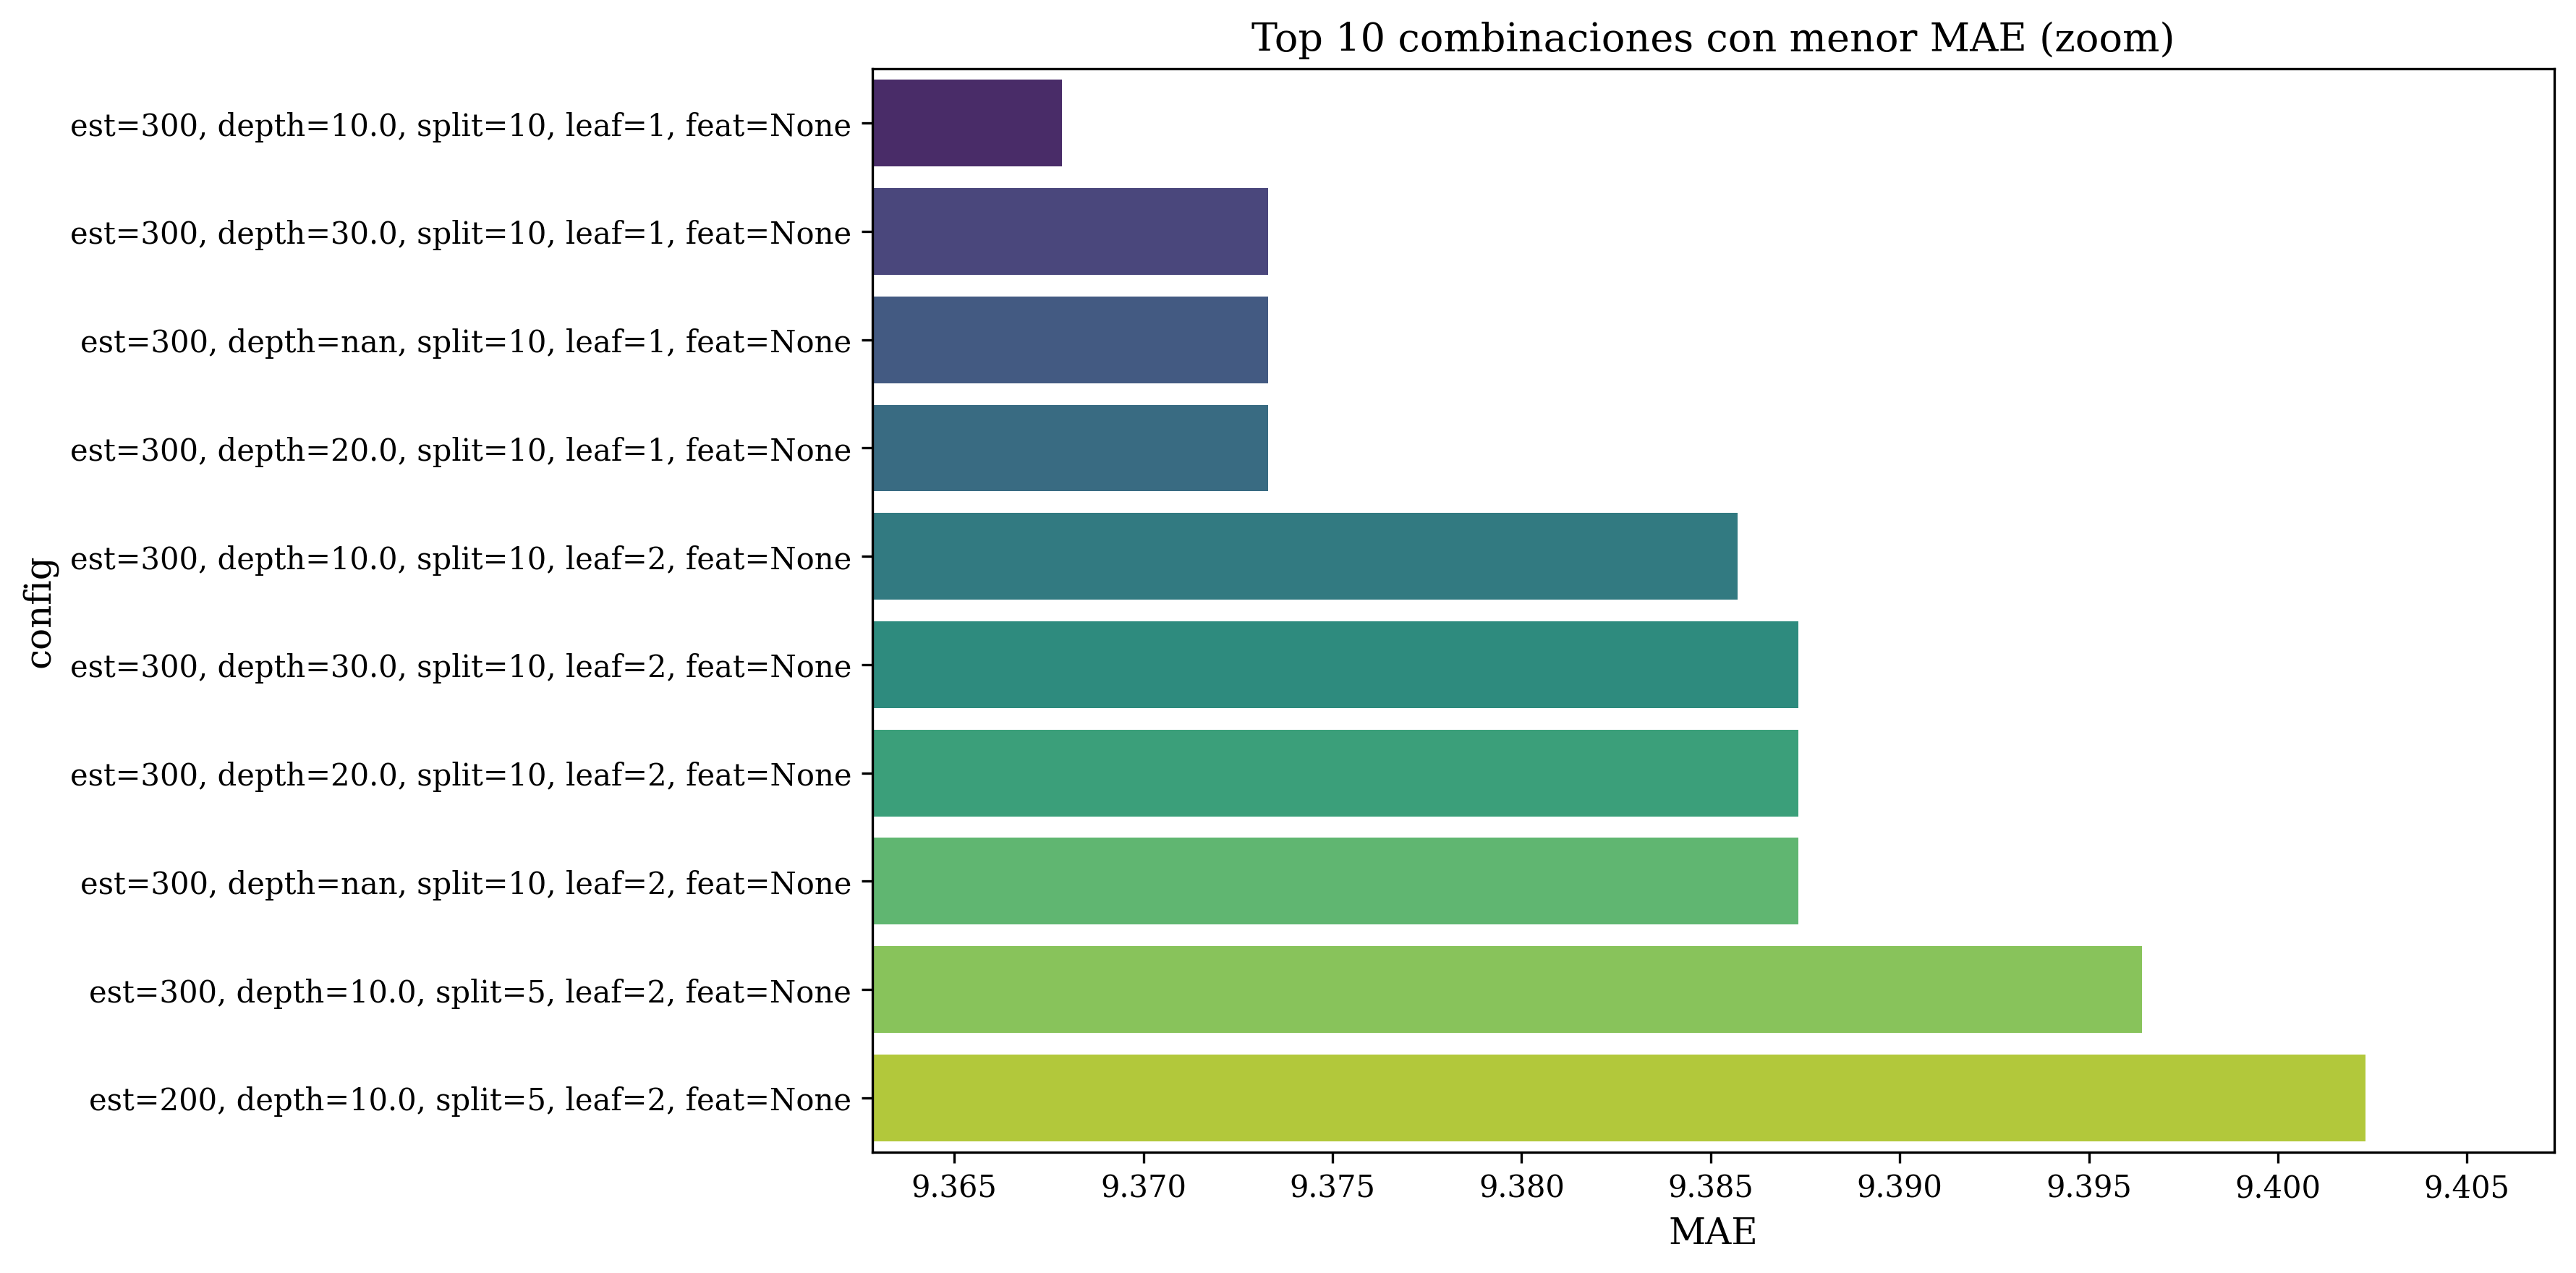

In [15]:
# Ordenar por MAE y seleccionar top 10
top_10 = resultados.sort_values(by='MAE').head(10).copy()

# Crear etiquetas legibles
top_10['config'] = top_10.apply(lambda row: f"est={row['n_estimators']}, depth={row['max_depth']}, "
                                            f"split={row['min_samples_split']}, leaf={row['min_samples_leaf']}, "
                                            f"feat={row['max_features']}", axis=1)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='MAE', y='config', data=top_10, hue='config', palette='viridis', legend=False)
plt.xlim(top_10['MAE'].min() - 0.005, top_10['MAE'].max() + 0.005)
plt.xlabel('MAE')
plt.title('Top 10 combinaciones con menor MAE (zoom)')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Usar el mejor modelo obtenido del RandomizedSearchCV
modelo_final_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features= None,
    random_state=42
)

# Entrenar el modelo con todos los datos de entrenamiento
modelo_final_rf.fit(X_train_scaled, y_train)

y_pred_rf = modelo_final_rf.predict(X_test_scaled)
# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print(" Métricas del modelo Random Forest:")
print(f"MAE  (Error absoluto medio):      {mae_rf:.2f}")
print(f"RMSE (Raíz del error cuadrático): {rmse_rf:.2f}")
print(f"R²   (Coeficiente de determinación): {r2_rf:.2f}")


 Métricas del modelo Random Forest:
MAE  (Error absoluto medio):      9.88
RMSE (Raíz del error cuadrático): 12.93
R²   (Coeficiente de determinación): 0.25


In [17]:
import joblib

# Guardar el modelo y el escalador
joblib.dump(modelo_final_rf, 'm_f_estudiantes.pkl')
joblib.dump(scaler, 'escalador_estus.pkl')

print("Modelo y escalador guardados exitosamente.")

Modelo y escalador guardados exitosamente.


In [18]:
# Cargar modelo y escalador
modelo_final = joblib.load('m_f_estudiantes.pkl')
scaler = joblib.load('escalador_estus.pkl')

In [19]:
# Separar variables y objetivo
X_val = df_val.drop(columns=['Total Estudiantes'])
y_val = df_val['Total Estudiantes']

# Detectar columnas numéricas
num_cols = X_val.select_dtypes(include=['int64', 'float64']).columns

# Aplicar el escalado a las columnas numéricas
X_val_scaled = X_val.copy()
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])

In [20]:
# Predecir con el modelo cargado
y_pred_val = modelo_final.predict(X_val_scaled)

mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print("Evaluación con el conjunto de validación (2024–2025):")
print(f"MAE  (Error absoluto medio):      {mae_val:.2f}")
print(f"RMSE (Raíz del error cuadrático): {rmse_val:.2f}")
print(f"R²   (Coeficiente de determinación): {r2_val:.2f}")

Evaluación con el conjunto de validación (2024–2025):
MAE  (Error absoluto medio):      8.45
RMSE (Raíz del error cuadrático): 11.17
R²   (Coeficiente de determinación): -0.02


In [42]:
# Generar predicciones
y_pred_train = modelo_final.predict(X_train_scaled)
y_pred_test = modelo_final.predict(X_test_scaled)

# Calcular los límites globales para los ejes
min_val = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
max_val = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())


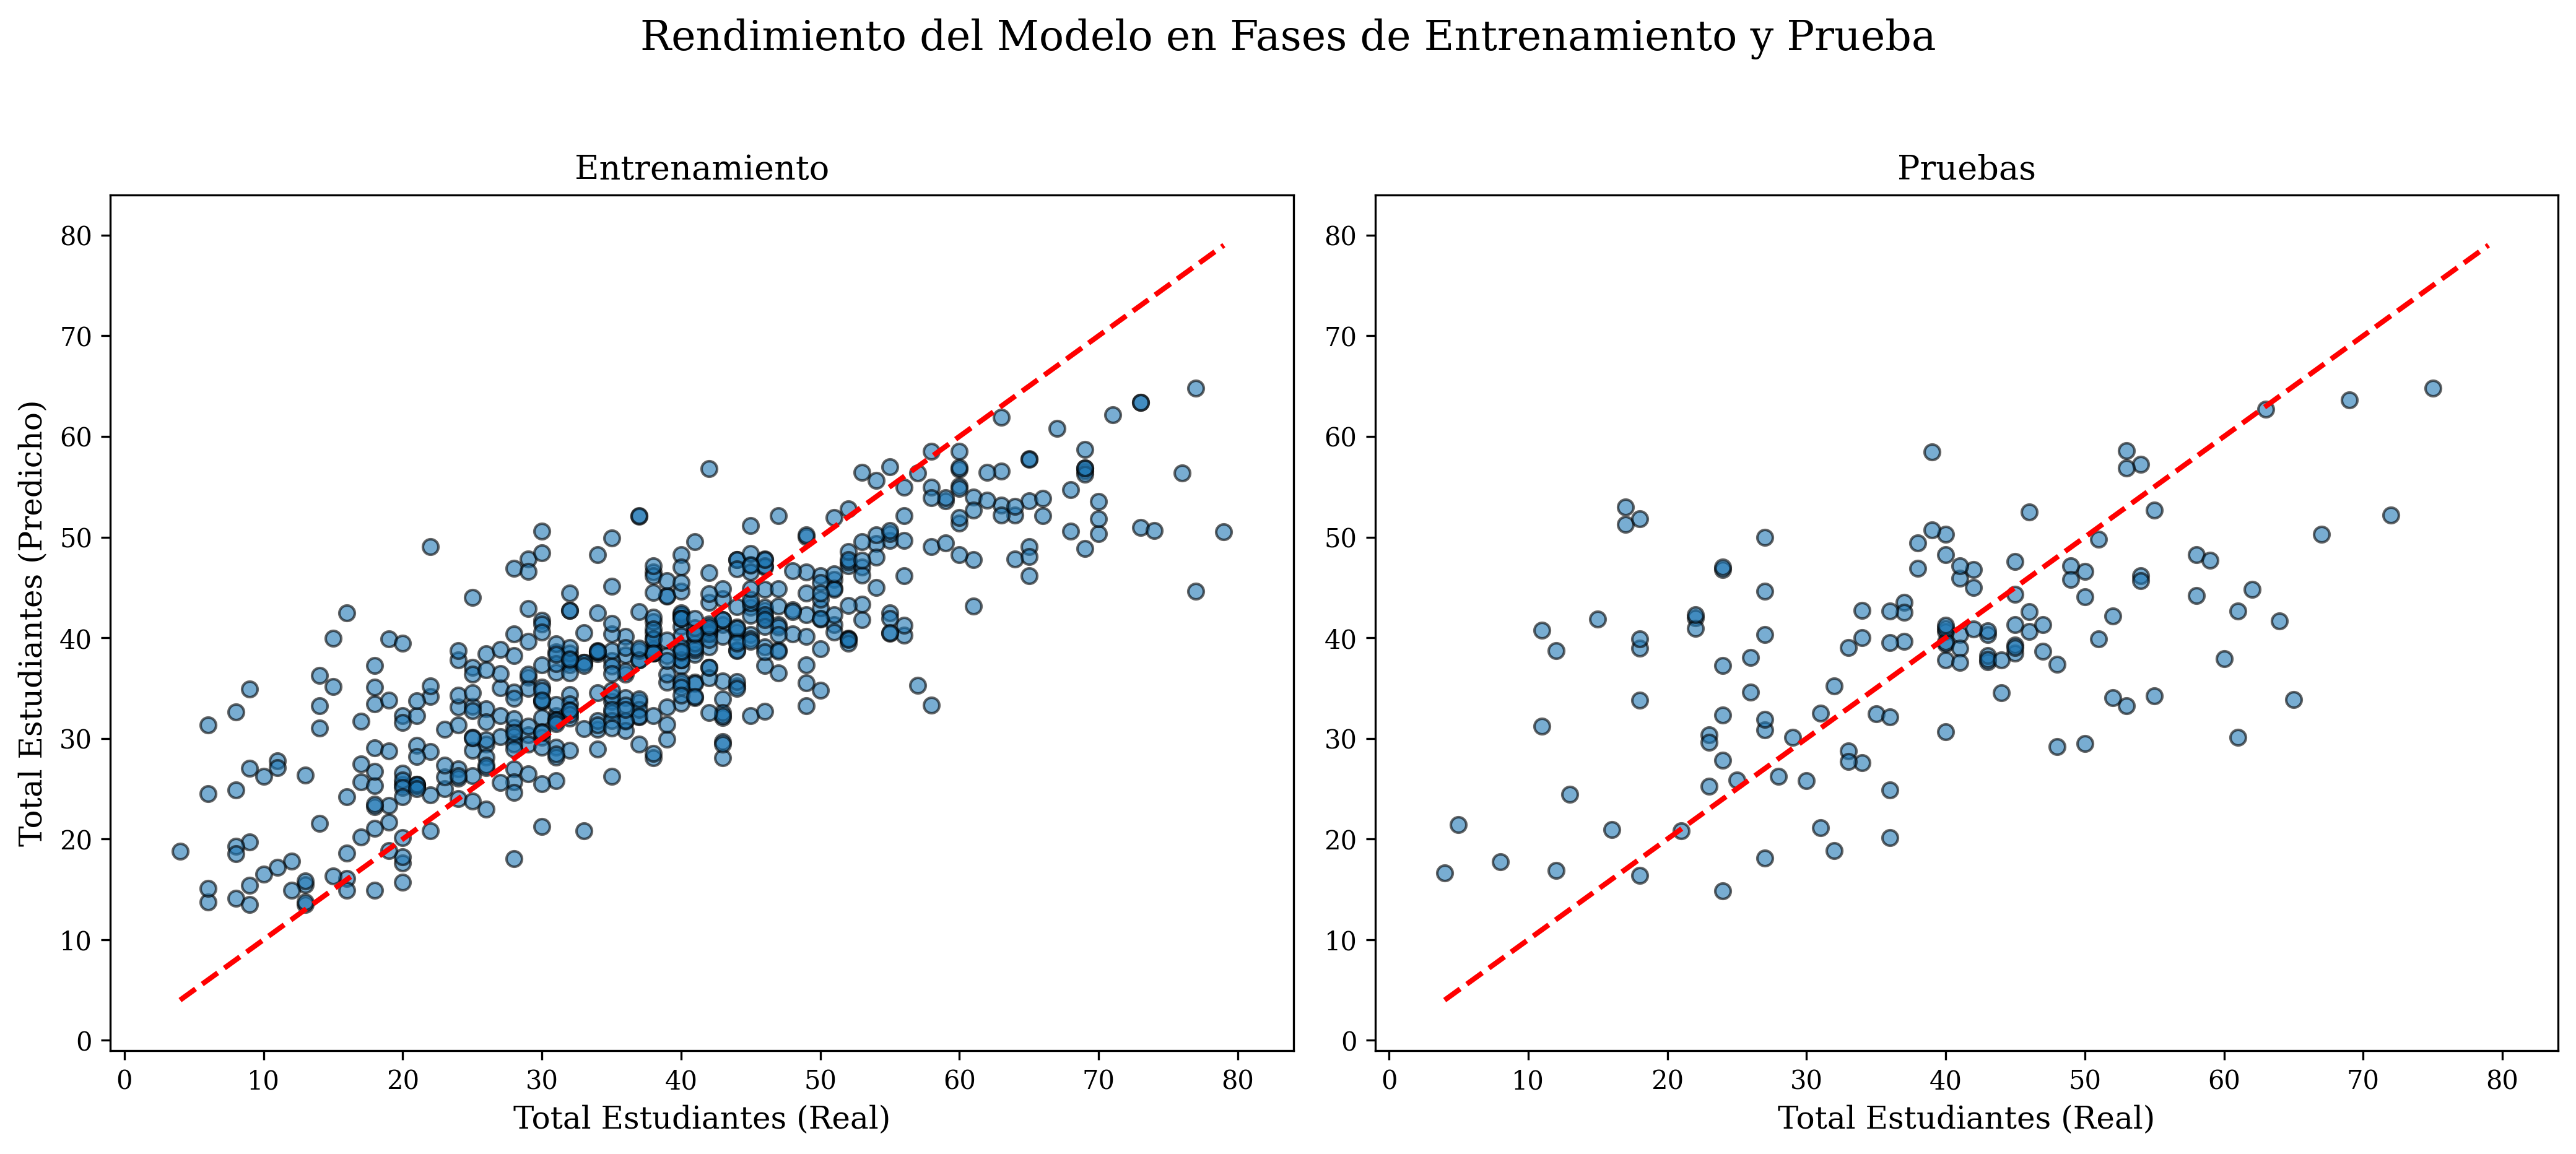

In [43]:
# Crear figura con dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Título general
fig.suptitle("Rendimiento del Modelo en Fases de Entrenamiento y Prueba", fontsize=16, y=1.03)

# === Gráfico 1: Entrenamiento ===
axes[0].scatter(y_train, y_pred_train, alpha=0.6, edgecolors='k')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_xlim(min_val - 5, max_val + 5)
axes[0].set_ylim(min_val - 5, max_val + 5)
axes[0].set_xlabel("Total Estudiantes (Real)")
axes[0].set_ylabel("Total Estudiantes (Predicho)")
axes[0].set_title("Entrenamiento")
axes[0].grid(False)  # Quitar la grilla

# === Gráfico 2: Pruebas ===
axes[1].scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_xlim(min_val - 5, max_val + 5)
axes[1].set_ylim(min_val - 5, max_val + 5)
axes[1].set_xlabel("Total Estudiantes (Real)")
# axes[1].set_ylabel("Total Estudiantes (Predicho)")
axes[1].set_title("Pruebas")
axes[1].grid(False)  # Quitar la grilla

plt.tight_layout()
plt.show()


In [44]:
# Calcular errores residuales
error_train = y_train - y_pred_train
error_test = y_test - y_pred_test
error_val = y_val - y_pred_val

# Unificar rangos de ejes
x_min = min(y_train.min(), y_test.min(), y_val.min())
x_max = max(y_train.max(), y_test.max(), y_val.max())
y_min = min(error_train.min(), error_test.min(), error_val.min())
y_max = max(error_train.max(), error_test.max(), error_val.max())


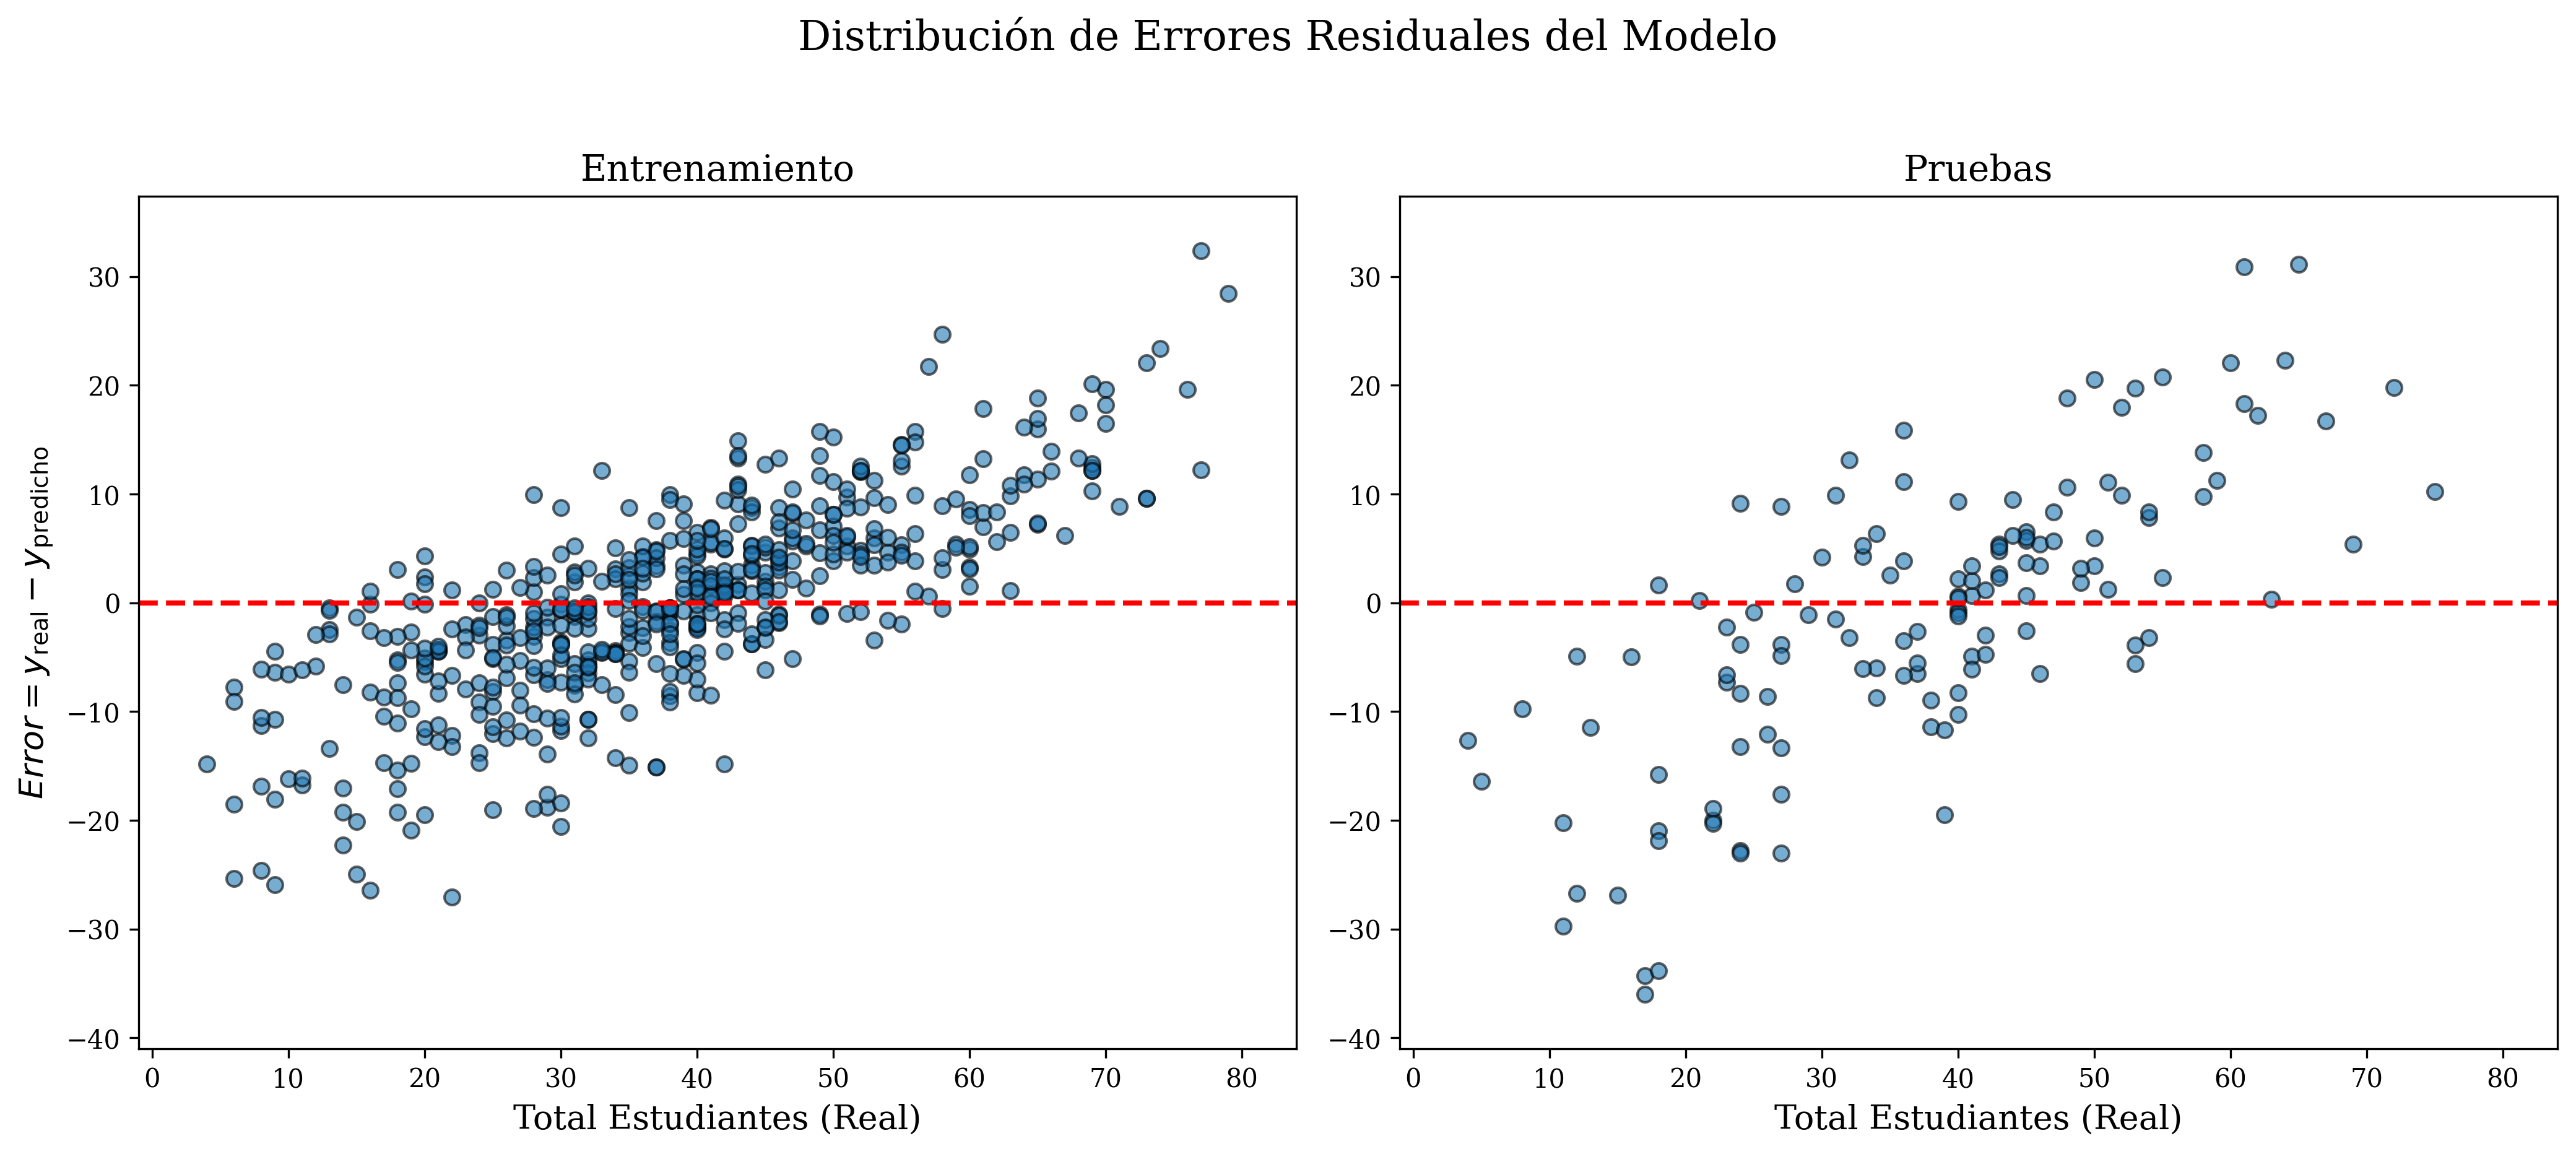

In [45]:
# Crear figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Título general
fig.suptitle("Distribución de Errores Residuales del Modelo", fontsize=16, y=1.03)

# Parámetros
label_fontsize = 13
title_fontsize = 14

# === Gráfico 1: Entrenamiento ===
axes[0].scatter(y_train, error_train, alpha=0.6, edgecolors='k')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel("Total Estudiantes (Real)", fontsize=label_fontsize)
axes[0].set_ylabel(r"$Error = y_{\mathrm{real}} - y_{\mathrm{predicho}}$", fontsize=label_fontsize)
axes[0].set_title("Entrenamiento", fontsize=title_fontsize)
axes[0].set_xlim(x_min - 5, x_max + 5)
axes[0].set_ylim(y_min - 5, y_max + 5)
axes[0].grid(False)  # Quitar grilla

# === Gráfico 2: Pruebas ===
axes[1].scatter(y_test, error_test, alpha=0.6, edgecolors='k')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel("Total Estudiantes (Real)", fontsize=label_fontsize)
axes[1].set_title("Pruebas", fontsize=title_fontsize)
axes[1].set_xlim(x_min - 5, x_max + 5)
axes[1].set_ylim(y_min - 5, y_max + 5)
axes[1].grid(False)  # Quitar grilla

plt.tight_layout()
plt.show()



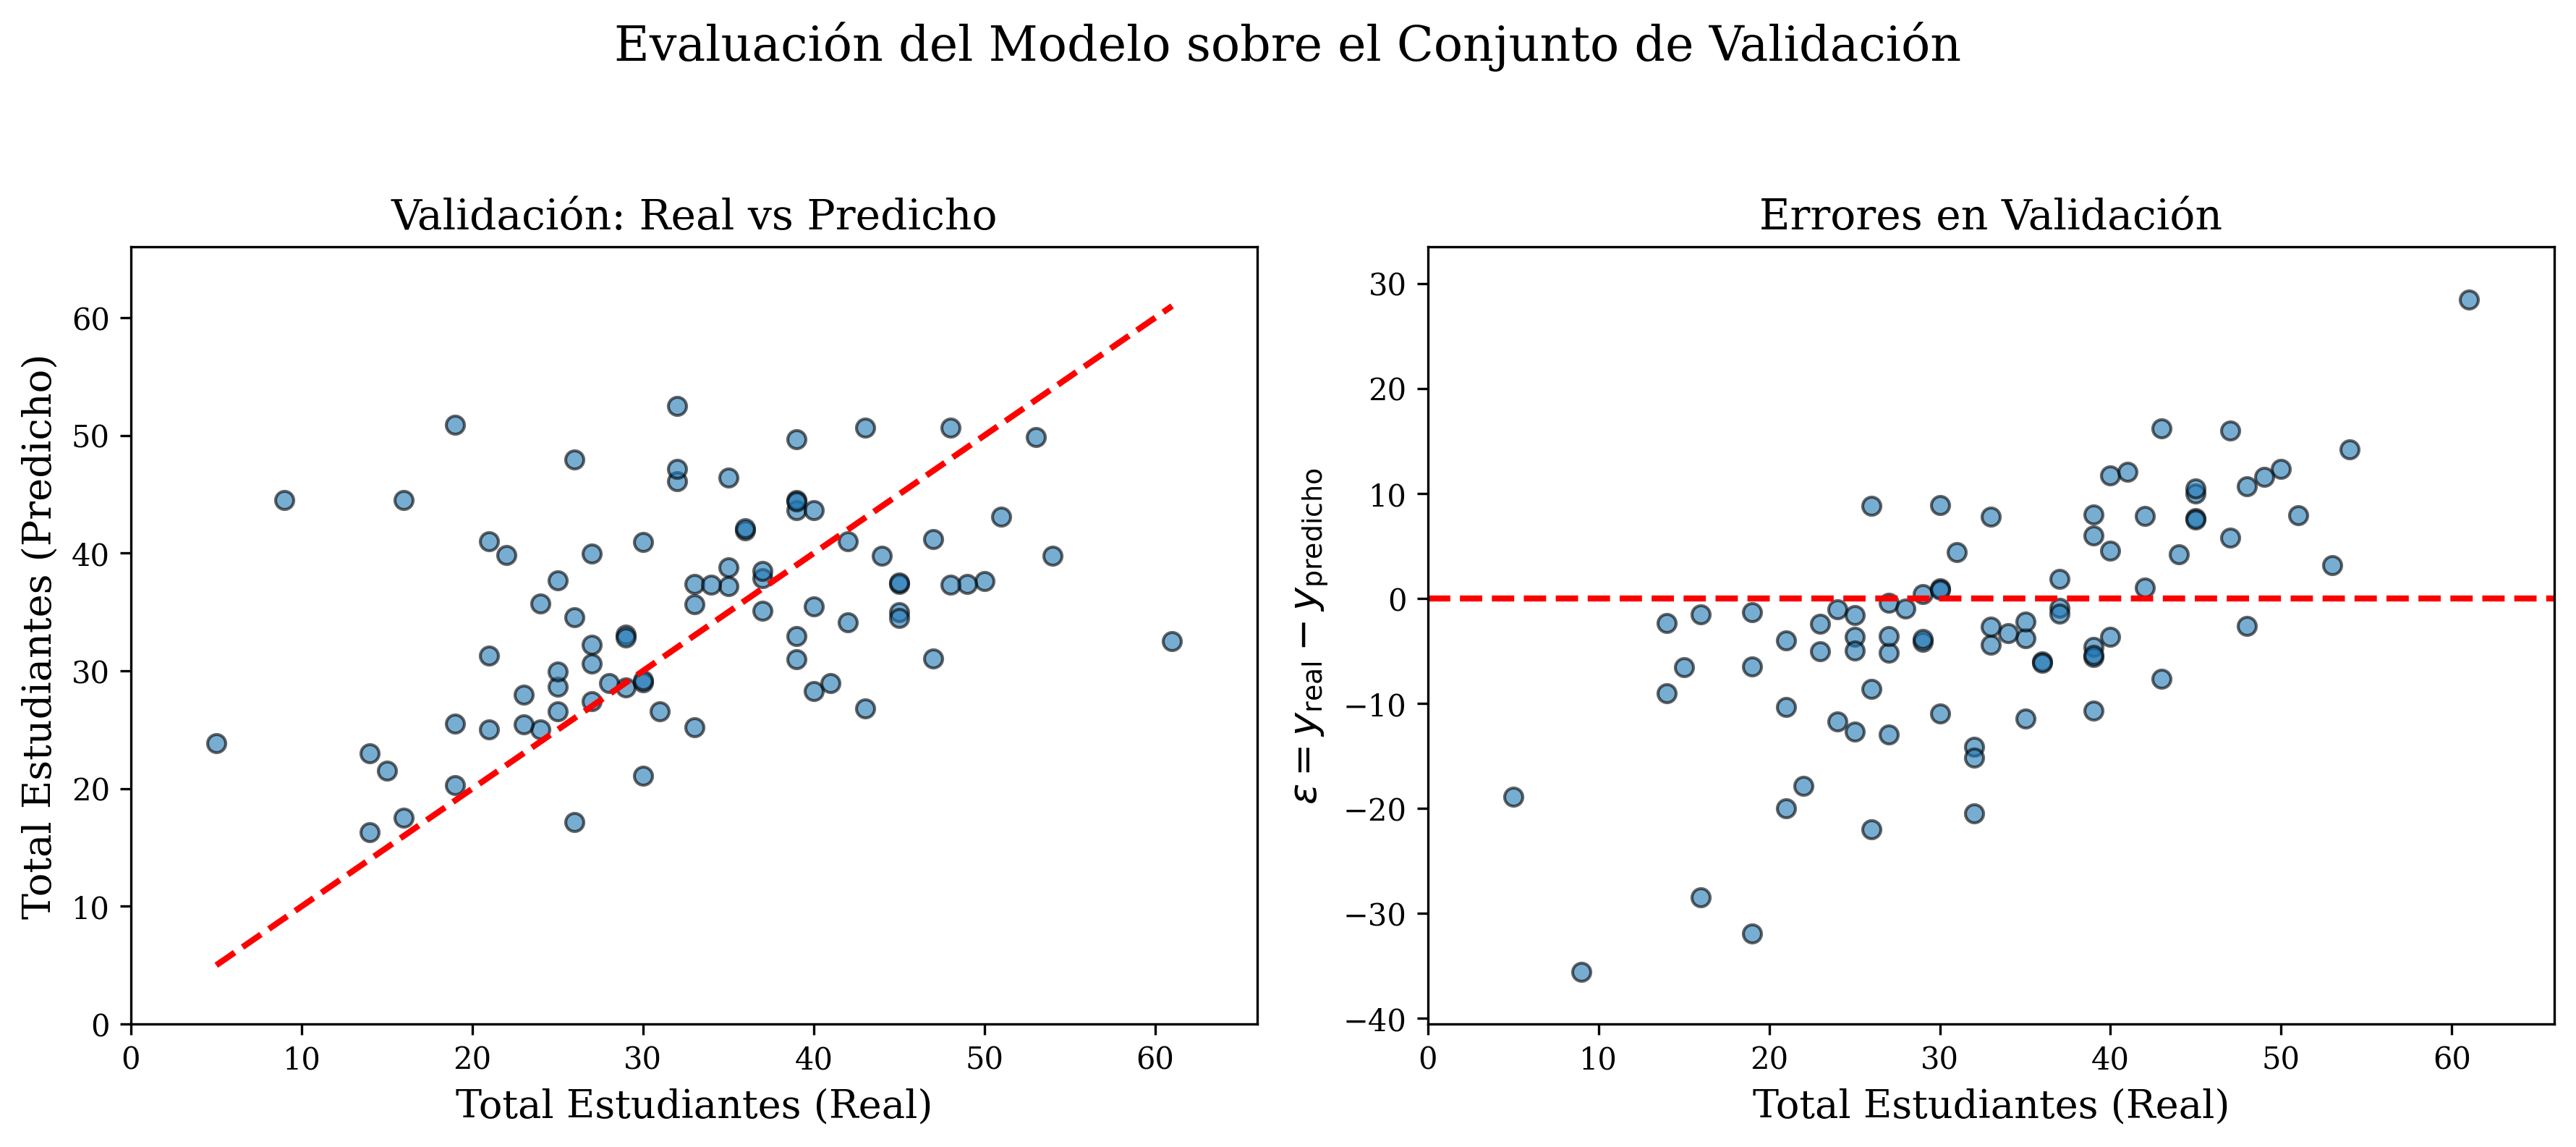

In [46]:
# Crear figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Parámetros comunes
label_fontsize = 13
title_fontsize = 14

# Rango común de ejes
x_min = min(y_val.min(), y_pred_val.min())
x_max = max(y_val.max(), y_pred_val.max())
error_val = y_val - y_pred_val
y_min = error_val.min()
y_max = error_val.max()

# === Gráfico 1: Real vs Predicho (Validación) ===
axes[0].scatter(y_val, y_pred_val, alpha=0.6, edgecolors='k')
axes[0].plot([x_min, x_max], [x_min, x_max], 'r--', linewidth=2)
axes[0].set_xlim(x_min - 5, x_max + 5)
axes[0].set_ylim(x_min - 5, x_max + 5)
axes[0].set_xlabel("Total Estudiantes (Real)", fontsize=label_fontsize)
axes[0].set_ylabel("Total Estudiantes (Predicho)", fontsize=label_fontsize)
axes[0].set_title("Validación: Real vs Predicho", fontsize=title_fontsize)
axes[0].grid(False)

# === Gráfico 2: Errores en Validación ===
axes[1].scatter(y_val, error_val, alpha=0.6, edgecolors='k')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlim(x_min - 5, x_max + 5)
axes[1].set_ylim(y_min - 5, y_max + 5)
axes[1].set_xlabel("Total Estudiantes (Real)", fontsize=label_fontsize)
axes[1].set_ylabel(r"$\varepsilon = y_{\mathrm{real}} - y_{\mathrm{predicho}}$", fontsize=label_fontsize)
axes[1].set_title("Errores en Validación", fontsize=title_fontsize)
axes[1].grid(False)

# Título general
fig.suptitle("Evaluación del Modelo sobre el Conjunto de Validación", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


In [47]:
# Crear DataFrame con resultados
df_estudiantes_final = df_val.copy()
df_estudiantes_final['Estudiantes_Predichos'] = y_pred_val
df_estudiantes_final['Error_Absoluto'] = np.abs(df_estudiantes_final['Total Estudiantes'] - df_estudiantes_final['Estudiantes_Predichos'])

# Error porcentual relativo
df_estudiantes_final['Error_Porcentual (%)'] = (df_estudiantes_final['Error_Absoluto'] / df_estudiantes_final['Total Estudiantes']) * 100


# Mostrar primeras filas
print(df_estudiantes_final[['Total Estudiantes', 'Estudiantes_Predichos', 'Error_Absoluto']].head())

     Total Estudiantes  Estudiantes_Predichos  Error_Absoluto
528                 19              50.925811       31.925811
529                 50              37.643768       12.356232
530                 39              49.656192       10.656192
531                 35              38.798348        3.798348
532                 35              46.445423       11.445423


In [26]:
print("\n Estadísticas de error:")
print(df_estudiantes_final[['Error_Absoluto', 'Error_Porcentual (%)']].describe())


 Estadísticas de error:
       Error_Absoluto  Error_Porcentual (%)
count       82.000000             82.000000
mean         8.454814             35.808198
std          7.341511             63.359280
min          0.417962              1.441247
25%          3.604532             10.653579
50%          6.306758             18.232202
75%         11.561498             33.982310
max         35.544706            394.941176


In [27]:
print("\n Top 5 casos con mayor error absoluto:")
print(df_estudiantes_final.sort_values(by='Error_Absoluto', ascending=False).head(5)[
    ['Total Estudiantes', 'Estudiantes_Predichos', 'Error_Absoluto', 'Error_Porcentual (%)']
])


 Top 5 casos con mayor error absoluto:
     Total Estudiantes  Estudiantes_Predichos  Error_Absoluto  \
595                  9              44.544706       35.544706   
528                 19              50.925811       31.925811   
548                 16              44.487943       28.487943   
609                 61              32.521374       28.478626   
580                 26              47.981953       21.981953   

     Error_Porcentual (%)  
595            394.941176  
528            168.030586  
548            178.049641  
609             46.686272  
580             84.545973  


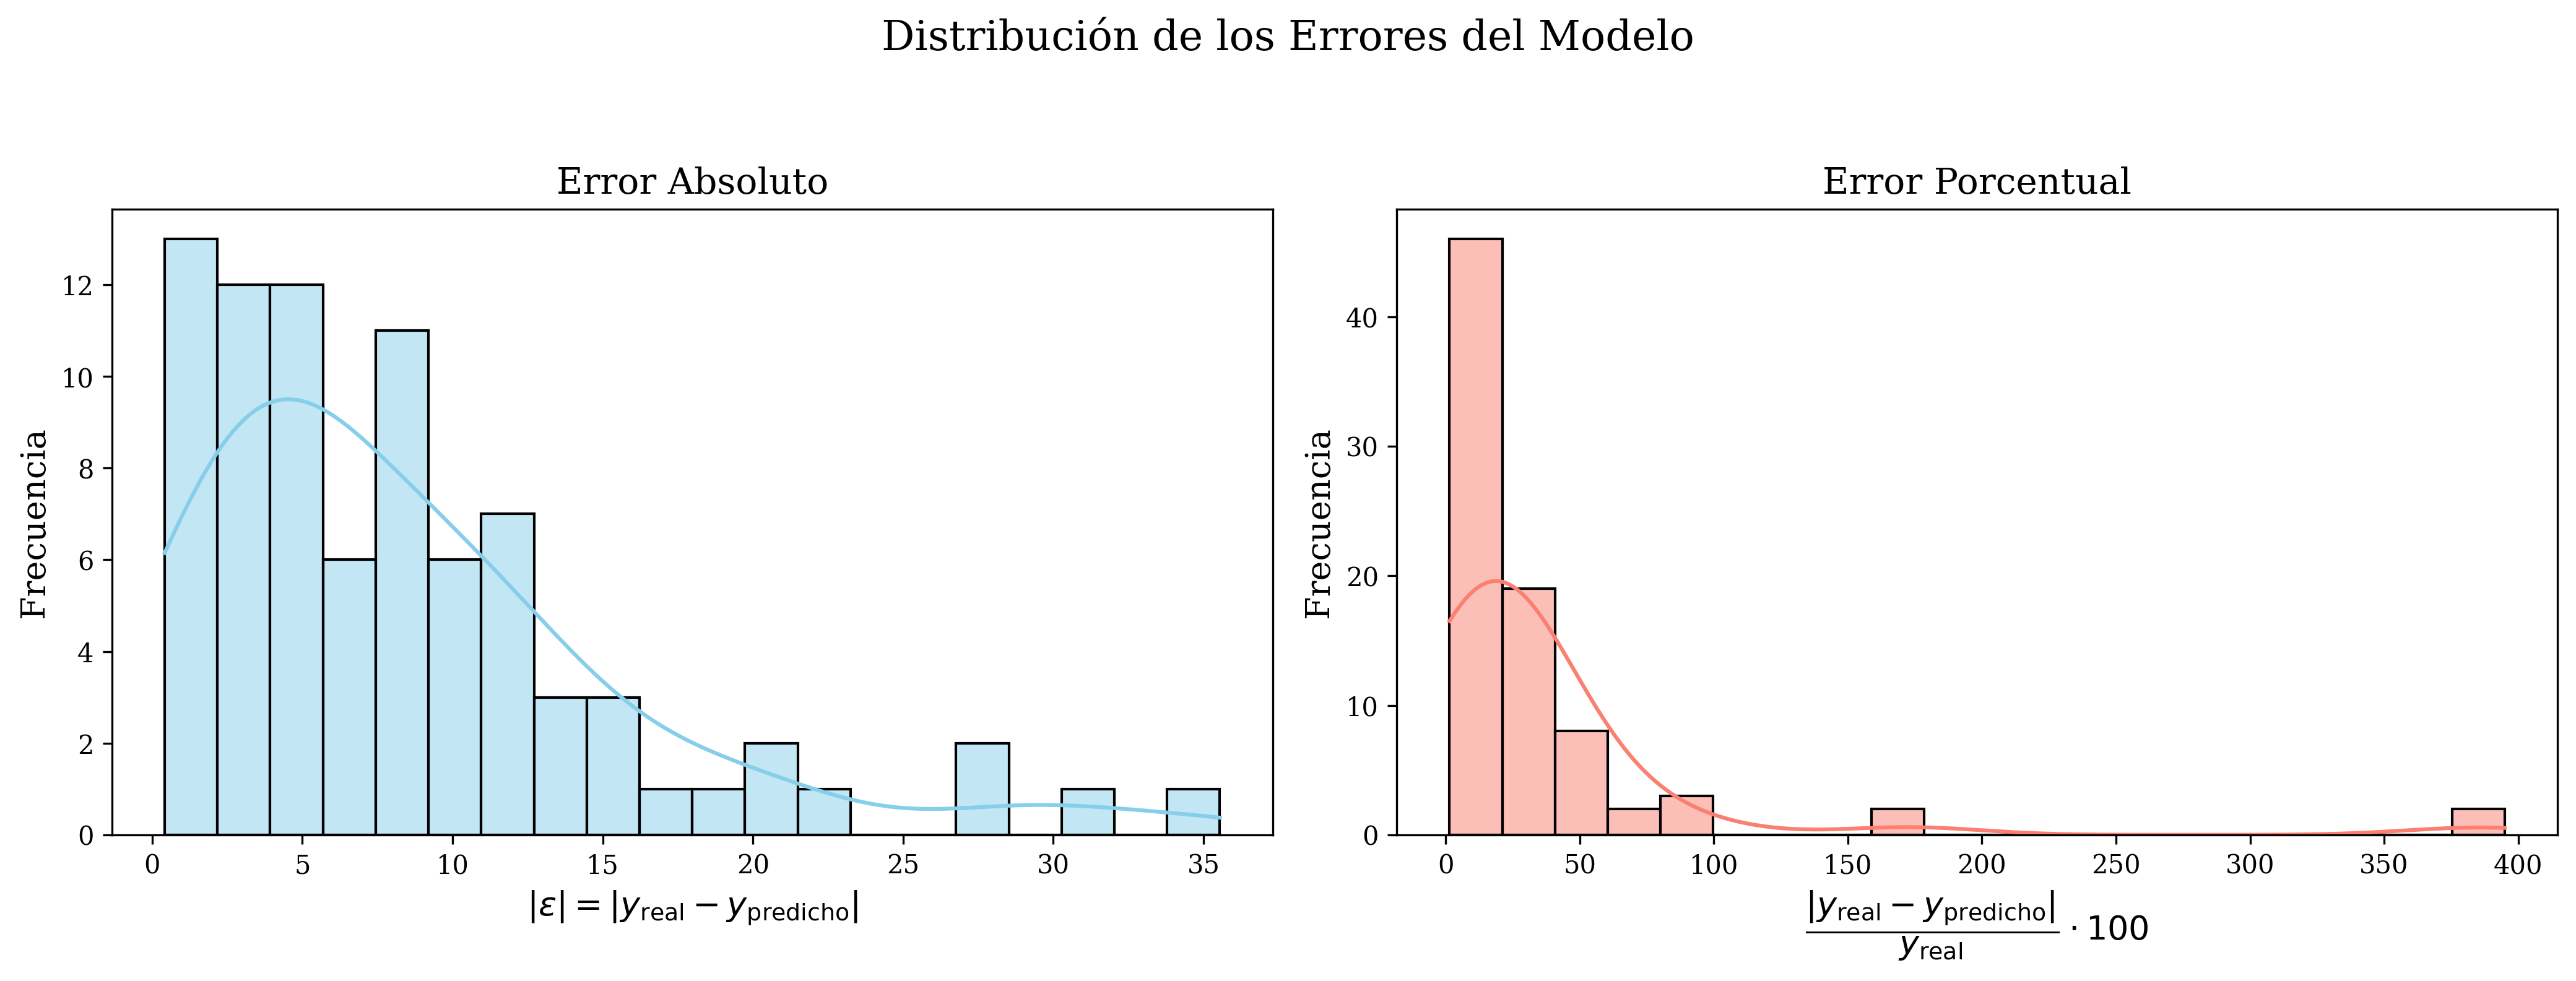

In [41]:
# Crear figura con 2 subplots en una sola fila
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# --- Histograma del Error Absoluto con KDE ---
sns.histplot(
    df_estudiantes_final['Error_Absoluto'],
    bins=20,
    kde=True,
    ax=axes[0],
    color='skyblue',
    edgecolor='black'
)
axes[0].set_title("Error Absoluto", fontsize=14)
axes[0].set_xlabel(r"$|\varepsilon| = |y_{\mathrm{real}} - y_{\mathrm{predicho}}|$", fontsize=13)
axes[0].set_ylabel("Frecuencia", fontsize=13)
axes[0].grid(False)

# --- Histograma del Error Porcentual con KDE ---
sns.histplot(
    df_estudiantes_final['Error_Porcentual (%)'],
    bins=20,
    kde=True,
    ax=axes[1],
    color='salmon',
    edgecolor='black'
)
axes[1].set_title("Error Porcentual", fontsize=14)
axes[1].set_xlabel(r"$\dfrac{|y_{\mathrm{real}} - y_{\mathrm{predicho}}|}{y_{\mathrm{real}}} \cdot 100$", fontsize=13)
axes[1].set_ylabel("Frecuencia", fontsize=13)
axes[1].grid(False)

# Título general
fig.suptitle("Distribución de los Errores del Modelo", fontsize=16, y=1.05)

# Ajustar diseño
plt.tight_layout()
plt.show()
